* Set objective function to glucose minimization
* Set upper bounds for biomass: 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 (0.30 is max Rhodotorula growth rate in lab)
* Find PPP enzymes fluxes: 'TALA'=Transaldolase, 'TKT1'=Transketolase, 'TKT2'=Transketolase, 'RPI'=Ribose-5-phosphate isomerase (RKI - vist), 'G6PDH2rp'=Glucose 6-phosphate dehydrogenase (ZWF), 'GND'=Phosphogluconate dehydrogenase (GND), 'PGLp'=6-phosphogluconolactonase
* And find ATPM & ACITL fluxes


In [2]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt


In [41]:
# Importing the model
model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")


In [42]:
# Changing the objective function
model.objective = "EX_glc__D_e" 
solution = model.optimize('minimize') # minimize the objective function
solution.objective_value # get the objective value i.e flux of the objective function
# print(model.objective.expression)
# print(model.objective.direction)
# solution

-1.0

In [43]:
# Change glucose bounds
model.reactions.get_by_id("EX_glc__D_e").upper_bound = 9999
model.reactions.get_by_id("EX_glc__D_e").lower_bound = -9999

In [36]:
# Get all fluxes
all_fluxes = solution.fluxes.to_frame(name='Flux') # solution.fluxes gives fluxes for all reactions, to_frame makes it a pandas dataframe
all_fluxes

,Flux
ALCD25yi,0.0
MTHFCm,0.0
AMPN,0.0
DAGCPTer_RT,0.0
PYRt2,0.0
...,...
FOLt,0.0
NADtm,0.0
EX_pydxn_e,0.0
PYDXNtr,0.0


In [7]:
# Get all fluxes on different GR
GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
flux_values_specific_GR = pd.DataFrame(columns=['GR', *all_fluxes.index], index=range(len(GR_range))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(GR_range)):
    model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
    solution = model.optimize('minimize')
    flux_values_specific_GR.loc[i] = solution.fluxes[['BIOMASS_RT', *all_fluxes.index]].values
# Example for finding a certain reaction flux: flux_values_specific_GR['EX_o2_e']
# flux_values_specific_GR

In [8]:
def fluxes_on_specific_GR(model, GR_range, enzymes, minimize = True):
    fluxes = pd.DataFrame(columns=['GR', *enzymes], index=range(len(GR_range)))
    for i in range(len(GR_range)):
        model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
        solution = model.optimize('minimize' if minimize else 'maximize')        
        fluxes.loc[i] = solution.fluxes[['BIOMASS_RT', *enzymes]].values
    return fluxes

In [37]:
# Fluxes for ATPM and ACITL
GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
enzymes = ['ATPM', 'ACITL']
ATPM_ACITL_fluxes = fluxes_on_specific_GR(model, GR_range, enzymes)
ATPM_ACITL_fluxes


,GR,ATPM,ACITL
0,0.05,1.22,0.0
1,0.1,1.22,0.0
2,0.15,1.22,0.0
3,0.2,1.22,0.0
4,0.25,1.22,0.0
5,0.3,1.22,0.0


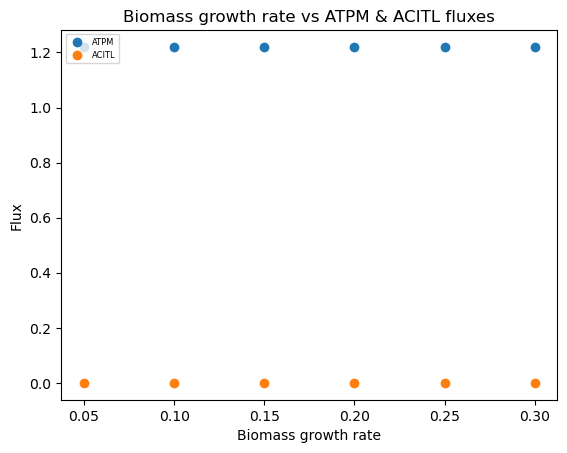

In [10]:
plt.plot(GR_range, np.abs(ATPM_ACITL_fluxes[['ATPM', 'ACITL']]), 'o', label=['ATPM', 'ACITL'])
plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Biomass growth rate vs ATPM & ACITL fluxes")
plt.legend(fontsize=6, loc='upper left')
plt.show()

In [23]:
# Get fluxes for PPP enzymes
# add phosphoketolase 'XPK', pyruvate decarboxylase 'PYRDC', pyruvate dehydrogenase 'PDHm'

GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
enzymes = ['G6PDH2rp', 'TKT1', 'TKT2', 'TALA', 'XPK','PYRDC','PDHm'] # Jätan välja 'RPI', 'PGLp'ja 'GND'
PPP_enzymes_fluxes = abs(fluxes_on_specific_GR(model, GR_range, enzymes))
PPP_enzymes_fluxes


,GR,G6PDH2rp,TKT1,TKT2,TALA,XPK,PYRDC,PDHm
0,0.05,0.0,4.92463,0.0,0.255571,10.194853,0.0,0.0
1,0.1,0.0,9.23926,0.0,0.511142,19.169707,0.0,0.0
2,0.15,0.0,13.553889,0.0,0.766714,28.14456,0.0,0.0
3,0.2,0.0,17.868519,0.0,1.022285,37.119414,0.0,0.0
4,0.25,0.0,22.183149,0.0,1.277856,46.094267,0.0,0.0
5,0.3,0.0,26.497779,0.0,1.533427,55.069121,0.0,0.0


In [24]:
# Change G6PDH2rp column name to oxpp 
PPP_enzymes_fluxes = PPP_enzymes_fluxes.rename(columns = {'G6PDH2rp': 'oxpp'})
PPP_enzymes_fluxes


,GR,oxpp,TKT1,TKT2,TALA,XPK,PYRDC,PDHm
0,0.05,0.0,4.92463,0.0,0.255571,10.194853,0.0,0.0
1,0.1,0.0,9.23926,0.0,0.511142,19.169707,0.0,0.0
2,0.15,0.0,13.553889,0.0,0.766714,28.14456,0.0,0.0
3,0.2,0.0,17.868519,0.0,1.022285,37.119414,0.0,0.0
4,0.25,0.0,22.183149,0.0,1.277856,46.094267,0.0,0.0
5,0.3,0.0,26.497779,0.0,1.533427,55.069121,0.0,0.0


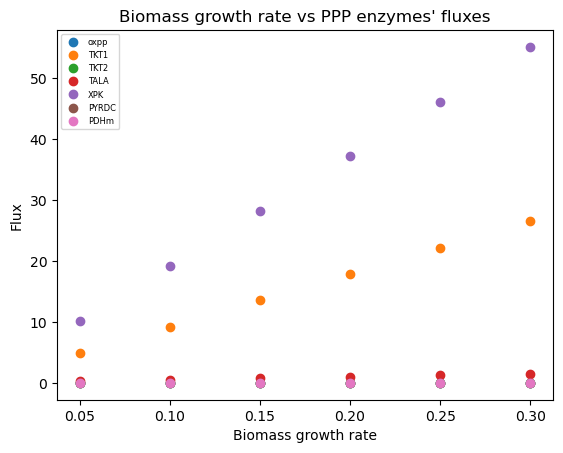

In [38]:
# Plot the PPP enzymes fluxes

plt.plot(PPP_enzymes_fluxes['GR'], PPP_enzymes_fluxes[['oxpp', 'TKT1', 'TKT2', 'TALA', 'XPK','PYRDC','PDHm']], 'o', label=['oxpp', 'TKT1', 'TKT2', 'TALA', 'XPK','PYRDC','PDHm'])
plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Biomass growth rate vs PPP enzymes' fluxes")
plt.legend(fontsize=6, loc='upper left')
plt.show()

# exchange_fluxes_all = model.summary().to_frame()
# exchange_fluxes_all = exchange_fluxes_all[abs(exchange_fluxes_all['flux']) != 0.01]
# exchange_fluxes_all = exchange_fluxes_all[['metabolite', 'flux']]
# # exchange_fluxes_all

In [40]:
# # Export DataFrames to excel - NB! Will overwrite the pages
# with pd.ExcelWriter("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Simulated_fluxes\\PPP_fluxes_glc_min.xlsx") as excel_writer:
#     PPP_enzymes_fluxes.to_excel(excel_writer, sheet_name='Sheet1', index=False)
#     ATPM_ACITL_fluxes.to_excel(excel_writer, sheet_name='Sheet2', index=False)


In [46]:
# from pathlib import Path
# from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model
# import logging
# for i in range(len(GR_range)):
#     model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
#     save_json_model(model, f"C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\edited_Rt_IFO0880_model_{GR_range[i]}.json")